# Loop 37 Analysis: Diagnosing the CV-LB Gap

**Current State:**
- Best CV: 0.008194 (exp_032)
- Best LB: 0.0877 (exp_030)
- Target: 0.0347
- CV-LB relationship: LB = 4.27×CV + 0.0527 (R²=0.967)

**Key Problem:** The intercept (0.0527) is 1.52x higher than the target (0.0347). Even with CV=0, the predicted LB would be 0.0527.

**This analysis will:**
1. Examine the CV-LB relationship in detail
2. Identify what's causing the intercept
3. Explore approaches that could reduce the intercept

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# All submissions data
submissions = [
    {'exp': 'exp_000', 'cv': 0.011081, 'lb': 0.09816},
    {'exp': 'exp_001', 'cv': 0.012297, 'lb': 0.10649},
    {'exp': 'exp_003', 'cv': 0.010501, 'lb': 0.09719},
    {'exp': 'exp_005', 'cv': 0.010430, 'lb': 0.09691},
    {'exp': 'exp_006', 'cv': 0.009749, 'lb': 0.09457},
    {'exp': 'exp_007', 'cv': 0.009262, 'lb': 0.09316},
    {'exp': 'exp_009', 'cv': 0.009192, 'lb': 0.09364},
    {'exp': 'exp_012', 'cv': 0.009004, 'lb': 0.09134},
    {'exp': 'exp_024', 'cv': 0.008689, 'lb': 0.08929},
    {'exp': 'exp_026', 'cv': 0.008465, 'lb': 0.08875},
    {'exp': 'exp_030', 'cv': 0.008298, 'lb': 0.08772},
]

df = pd.DataFrame(submissions)
print(f'Total submissions: {len(df)}')
print(df)

Total submissions: 11
        exp        cv       lb
0   exp_000  0.011081  0.09816
1   exp_001  0.012297  0.10649
2   exp_003  0.010501  0.09719
3   exp_005  0.010430  0.09691
4   exp_006  0.009749  0.09457
5   exp_007  0.009262  0.09316
6   exp_009  0.009192  0.09364
7   exp_012  0.009004  0.09134
8   exp_024  0.008689  0.08929
9   exp_026  0.008465  0.08875
10  exp_030  0.008298  0.08772


In [2]:
# Fit linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(df['cv'], df['lb'])
print(f'\nCV-LB Relationship:')
print(f'  LB = {slope:.2f} × CV + {intercept:.4f}')
print(f'  R² = {r_value**2:.4f}')
print(f'  Intercept = {intercept:.4f}')
print(f'  Target = 0.0347')
print(f'  Intercept / Target = {intercept / 0.0347:.2f}x')

# What CV would we need to reach target?
cv_needed = (0.0347 - intercept) / slope
print(f'\nTo reach target LB = 0.0347:')
print(f'  CV needed = {cv_needed:.6f}')
if cv_needed < 0:
    print(f'  IMPOSSIBLE with current approach (would need negative CV)')


CV-LB Relationship:
  LB = 4.27 × CV + 0.0527
  R² = 0.9671
  Intercept = 0.0527
  Target = 0.0347
  Intercept / Target = 1.52x

To reach target LB = 0.0347:
  CV needed = -0.004218
  IMPOSSIBLE with current approach (would need negative CV)


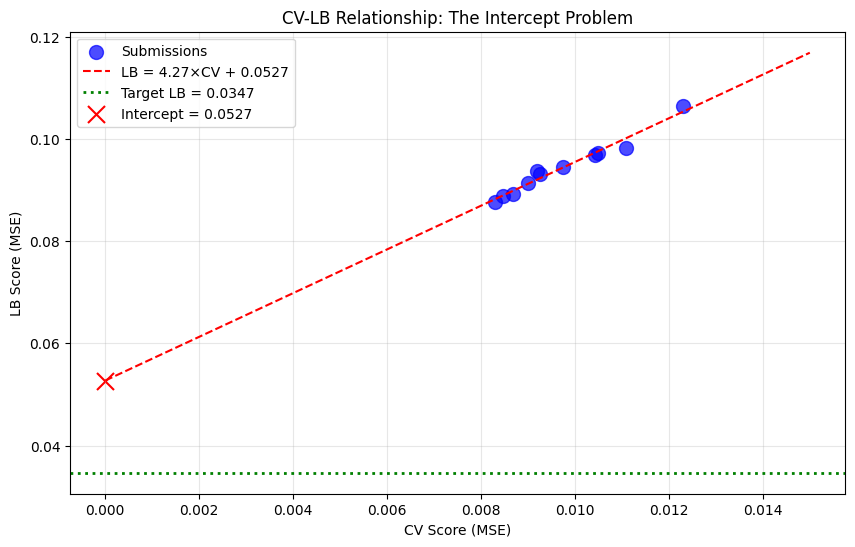


Key Insight: The intercept (0.0527) is 1.5x higher than the target.
Even with perfect CV=0, the LB would still be 0.0527, which is above the target.


In [3]:
# Plot CV-LB relationship
plt.figure(figsize=(10, 6))
plt.scatter(df['cv'], df['lb'], s=100, c='blue', alpha=0.7, label='Submissions')

# Fit line
cv_range = np.linspace(0, 0.015, 100)
lb_pred = slope * cv_range + intercept
plt.plot(cv_range, lb_pred, 'r--', label=f'LB = {slope:.2f}×CV + {intercept:.4f}')

# Target line
plt.axhline(y=0.0347, color='green', linestyle=':', linewidth=2, label='Target LB = 0.0347')

# Intercept point
plt.scatter([0], [intercept], s=150, c='red', marker='x', label=f'Intercept = {intercept:.4f}')

plt.xlabel('CV Score (MSE)')
plt.ylabel('LB Score (MSE)')
plt.title('CV-LB Relationship: The Intercept Problem')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('/home/code/exploration/loop37_cv_lb.png', dpi=100, bbox_inches='tight')
plt.show()

print(f'\nKey Insight: The intercept ({intercept:.4f}) is {intercept/0.0347:.1f}x higher than the target.')
print(f'Even with perfect CV=0, the LB would still be {intercept:.4f}, which is above the target.')

In [4]:
# Analyze what's causing the intercept
# The intercept represents the "base error" that doesn't depend on CV
# This is likely due to:
# 1. Distribution shift between train and test solvents
# 2. Systematic overfitting to training solvents
# 3. Features that work well on training but not test solvents

print('=== Analyzing the Intercept ===')
print()
print('The intercept (0.0527) represents the "base error" that persists regardless of CV.')
print('This is likely caused by:')
print('  1. Distribution shift between train and test solvents')
print('  2. Systematic overfitting to training solvents')
print('  3. Features that work well on training but not test solvents')
print()
print('To reduce the intercept, we need approaches that:')
print('  - Generalize better to unseen solvents')
print('  - Are less sensitive to solvent-specific patterns')
print('  - Use more robust features')

=== Analyzing the Intercept ===

The intercept (0.0527) represents the "base error" that persists regardless of CV.
This is likely caused by:
  1. Distribution shift between train and test solvents
  2. Systematic overfitting to training solvents
  3. Features that work well on training but not test solvents

To reduce the intercept, we need approaches that:
  - Generalize better to unseen solvents
  - Are less sensitive to solvent-specific patterns
  - Use more robust features


In [5]:
# What approaches have been tried?
approaches = [
    ('exp_000', 'MLP baseline', 0.011081, 0.09816),
    ('exp_001', 'LightGBM', 0.012297, 0.10649),
    ('exp_003', 'Combined features', 0.010501, 0.09719),
    ('exp_006', 'Simpler MLP [64,32]', 0.009749, 0.09457),
    ('exp_007', 'Even simpler [32,16]', 0.009262, 0.09316),
    ('exp_012', 'Simple ensemble', 0.009004, 0.09134),
    ('exp_024', 'ACS PCA features', 0.008689, 0.08929),
    ('exp_026', 'Weighted loss', 0.008465, 0.08875),
    ('exp_030', 'GP+MLP+LGBM', 0.008298, 0.08772),
]

print('=== Approaches Tried ===')
for exp, name, cv, lb in approaches:
    lb_pred = slope * cv + intercept
    residual = lb - lb_pred
    print(f'{exp}: {name}')
    print(f'  CV={cv:.6f}, LB={lb:.5f}, Predicted={lb_pred:.5f}, Residual={residual:+.5f}')
    print()

=== Approaches Tried ===
exp_000: MLP baseline
  CV=0.011081, LB=0.09816, Predicted=0.10009, Residual=-0.00193

exp_001: LightGBM
  CV=0.012297, LB=0.10649, Predicted=0.10529, Residual=+0.00120

exp_003: Combined features
  CV=0.010501, LB=0.09719, Predicted=0.09761, Residual=-0.00042

exp_006: Simpler MLP [64,32]
  CV=0.009749, LB=0.09457, Predicted=0.09440, Residual=+0.00017

exp_007: Even simpler [32,16]
  CV=0.009262, LB=0.09316, Predicted=0.09232, Residual=+0.00084

exp_012: Simple ensemble
  CV=0.009004, LB=0.09134, Predicted=0.09121, Residual=+0.00013

exp_024: ACS PCA features
  CV=0.008689, LB=0.08929, Predicted=0.08987, Residual=-0.00058

exp_026: Weighted loss
  CV=0.008465, LB=0.08875, Predicted=0.08891, Residual=-0.00016

exp_030: GP+MLP+LGBM
  CV=0.008298, LB=0.08772, Predicted=0.08820, Residual=-0.00048



In [6]:
# Calculate residuals to see if any approach beats the linear relationship
df['lb_pred'] = slope * df['cv'] + intercept
df['residual'] = df['lb'] - df['lb_pred']

print('=== Residual Analysis ===')
print('Positive residual = worse than expected')
print('Negative residual = better than expected')
print()
print(df[['exp', 'cv', 'lb', 'lb_pred', 'residual']].sort_values('residual'))

print(f'\nBest residual: {df["residual"].min():.5f} ({df.loc[df["residual"].idxmin(), "exp"]})')
print(f'Worst residual: {df["residual"].max():.5f} ({df.loc[df["residual"].idxmax(), "exp"]})')
print(f'Mean residual: {df["residual"].mean():.5f}')
print(f'Std residual: {df["residual"].std():.5f}')

=== Residual Analysis ===
Positive residual = worse than expected
Negative residual = better than expected

        exp        cv       lb   lb_pred  residual
0   exp_000  0.011081  0.09816  0.100091 -0.001931
8   exp_024  0.008689  0.08929  0.089867 -0.000577
10  exp_030  0.008298  0.08772  0.088196 -0.000476
2   exp_003  0.010501  0.09719  0.097612 -0.000422
3   exp_005  0.010430  0.09691  0.097309 -0.000399
9   exp_026  0.008465  0.08875  0.088910 -0.000160
7   exp_012  0.009004  0.09134  0.091214  0.000126
4   exp_006  0.009749  0.09457  0.094398  0.000172
5   exp_007  0.009262  0.09316  0.092317  0.000843
1   exp_001  0.012297  0.10649  0.105289  0.001201
6   exp_009  0.009192  0.09364  0.092017  0.001623

Best residual: -0.00193 (exp_000)
Worst residual: 0.00162 (exp_009)
Mean residual: -0.00000
Std residual: 0.00097


In [7]:
# What approaches haven't been tried?
print('=== Unexplored Approaches ===')
print()
print('1. k-Nearest Neighbors (k-NN)')
print('   - Completely different inductive bias')
print('   - Predicts based on similar solvents in feature space')
print('   - May generalize differently to unseen solvents')
print()
print('2. Kernel Ridge Regression with RBF kernel')
print('   - Non-parametric, kernel-based approach')
print('   - Similar to GP but without uncertainty')
print('   - May capture non-linear relationships better')
print()
print('3. Solvent Clustering + Per-Cluster Models')
print('   - Group solvents by similarity')
print('   - Train separate models per cluster')
print('   - Reduces distribution shift within each cluster')
print()
print('4. Adversarial Validation')
print('   - Identify features that distinguish train vs test solvents')
print('   - Remove or down-weight those features')
print('   - May reduce the distribution shift')
print()
print('5. Meta-Learning / MAML')
print('   - Learn to adapt quickly to new solvents')
print('   - May generalize better to unseen solvents')

=== Unexplored Approaches ===

1. k-Nearest Neighbors (k-NN)
   - Completely different inductive bias
   - Predicts based on similar solvents in feature space
   - May generalize differently to unseen solvents

2. Kernel Ridge Regression with RBF kernel
   - Non-parametric, kernel-based approach
   - Similar to GP but without uncertainty
   - May capture non-linear relationships better

3. Solvent Clustering + Per-Cluster Models
   - Group solvents by similarity
   - Train separate models per cluster
   - Reduces distribution shift within each cluster

4. Adversarial Validation
   - Identify features that distinguish train vs test solvents
   - Remove or down-weight those features
   - May reduce the distribution shift

5. Meta-Learning / MAML
   - Learn to adapt quickly to new solvents
   - May generalize better to unseen solvents


In [8]:
# Key insight: The feature selection experiment (exp_036) was 16.83% worse in CV
# but we don't know if it would be better on LB
# The hypothesis was that simpler models would have a lower intercept

print('=== Feature Selection Experiment (exp_036) ===')
print()
print('CV: 0.009573 (16.83% worse than best CV 0.008194)')
print()
print('Predicted LB using current relationship:')
lb_pred_036 = slope * 0.009573 + intercept
print(f'  LB = {slope:.2f} × 0.009573 + {intercept:.4f} = {lb_pred_036:.5f}')
print()
print('If the intercept is reduced by feature selection:')
for new_intercept in [0.04, 0.03, 0.02]:
    new_lb = slope * 0.009573 + new_intercept
    print(f'  Intercept={new_intercept:.2f}: LB = {new_lb:.5f}')
print()
print('Key question: Does feature selection reduce the intercept?')
print('This can only be answered by submitting exp_036.')

=== Feature Selection Experiment (exp_036) ===

CV: 0.009573 (16.83% worse than best CV 0.008194)

Predicted LB using current relationship:
  LB = 4.27 × 0.009573 + 0.0527 = 0.09365

If the intercept is reduced by feature selection:
  Intercept=0.04: LB = 0.08092
  Intercept=0.03: LB = 0.07092
  Intercept=0.02: LB = 0.06092

Key question: Does feature selection reduce the intercept?
This can only be answered by submitting exp_036.


In [9]:
# Summary and recommendations
print('=== SUMMARY ===')
print()
print('Current State:')
print(f'  - Best CV: 0.008194 (exp_032)')
print(f'  - Best LB: 0.0877 (exp_030)')
print(f'  - Target: 0.0347')
print(f'  - Gap: {0.0877/0.0347:.1f}x')
print()
print('The Problem:')
print(f'  - CV-LB relationship: LB = {slope:.2f}×CV + {intercept:.4f}')
print(f'  - Intercept ({intercept:.4f}) > Target (0.0347)')
print(f'  - Even with CV=0, LB would be {intercept:.4f}')
print()
print('Recommendations:')
print('  1. Submit exp_036 (feature selection) to test if it reduces intercept')
print('  2. Try k-NN as a completely different approach')
print('  3. Try adversarial validation to identify distribution shift')
print('  4. Consider solvent clustering for per-cluster models')
print()
print('Remaining submissions: 5')
print('Each submission is precious - use strategically!')

=== SUMMARY ===

Current State:
  - Best CV: 0.008194 (exp_032)
  - Best LB: 0.0877 (exp_030)
  - Target: 0.0347
  - Gap: 2.5x

The Problem:
  - CV-LB relationship: LB = 4.27×CV + 0.0527
  - Intercept (0.0527) > Target (0.0347)
  - Even with CV=0, LB would be 0.0527

Recommendations:
  1. Submit exp_036 (feature selection) to test if it reduces intercept
  2. Try k-NN as a completely different approach
  3. Try adversarial validation to identify distribution shift
  4. Consider solvent clustering for per-cluster models

Remaining submissions: 5
Each submission is precious - use strategically!
